# Step 1: Data Retrival

To get the data downloaded from the Wikipedia page, we will use the `requests` library to get the HTML of the page. We will use the `BeautifulSoup` library to parse the HTML data. Additionally we will clean up abit of the data.

In [14]:
import requests
from bs4 import BeautifulSoup
import csv
import re 

url = 'https://en.wikipedia.org/wiki/February_29'

def fetch(url):
    response = requests.get(url)
    if response.status_code == 200:
        return BeautifulSoup(response.content, 'html.parser')
    else:
        print(f"Error fetching the webpage: Status code {response.status_code}")
        return None

def extract_records(soup, heading_id):
    if soup is None:
        return []

    records = []
    id_counter = 1
    heading_span = soup.find("span", {"id": heading_id})
    if not heading_span:
        return records 

    current_element = heading_span.parent 
    while True:
        current_element = current_element.find_next_sibling()
        if not current_element or current_element.name == "h2":
            break 
        if current_element.name == "h3":

            ul = current_element.find_next_sibling("ul")
            if ul:
                for li in ul.find_all("li"):
                    text = li.get_text()
                    try:
                        year, name = text.split('–', 1)
                        year = year.strip()
                        name = re.sub(r'\[\d+\]', '', name) 
                        name = re.sub(r'\(d\.\s*\d+\)', '', name).strip() 
                        records.append({'id': id_counter, 'name': name, 'year': year})
                        id_counter += 1
                    except ValueError:
                        continue
    return records



def save_to_csv(records, filename):
    with open(filename, 'w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['id', 'name', 'year'])
        writer.writeheader()
        for record in records:
            writer.writerow(record)

soup = fetch(url)
births = extract_records(soup, 'Births')
deaths = extract_records(soup, 'Deaths')
save_to_csv(births, 'births.csv')
save_to_csv(deaths, 'deaths.csv')
print("Births and deaths have been saved to 'births.csv' and 'deaths.csv'")

Births and deaths have been saved to 'births.csv' and 'deaths.csv'


# Step 2: Preparing the Data

We will use the `pandas` library to create a dataframe from the parsed data.

In [19]:
import pandas as pd

births_df = pd.read_csv('./births.csv')
deaths_df = pd.read_csv('./deaths.csv')

births_df['year'] = pd.to_datetime(births_df['year'], format='%Y', errors='coerce')
deaths_df['year'] = pd.to_datetime(deaths_df['year'], format='%Y', errors='coerce')

births_df = births_df.dropna(subset=['year'])
deaths_df = deaths_df.dropna(subset=['year'])

births_df['year'] = births_df['year'].dt.year
deaths_df['year'] = deaths_df['year'].dt.year

births_count = births_df.groupby('year').size()
deaths_count = deaths_df.groupby('year').size()


# Step 3: 

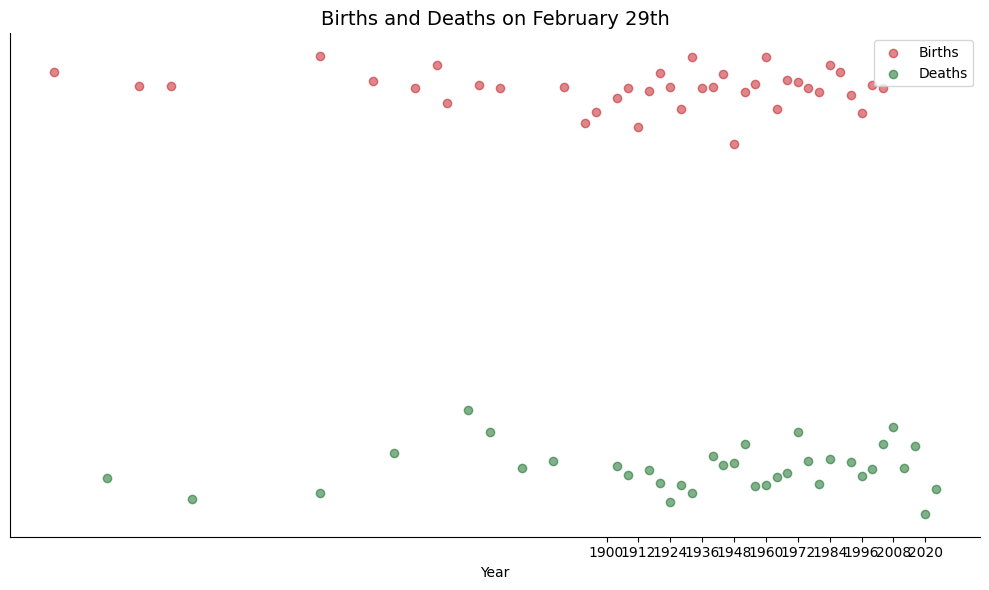

In [21]:
import matplotlib.pyplot as plt
import numpy as np


births_x = births_count.index
births_y = np.random.normal(1, 0.1, size=len(births_count))

deaths_x = deaths_count.index
deaths_y = np.random.normal(-1, 0.1, size=len(deaths_count))

fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for births and deaths
ax.scatter(births_x, births_y, color="#BF1019", alpha=0.5, label='Births')
ax.scatter(deaths_x, deaths_y, color="#056517", alpha=0.5, label='Deaths')

# Customizing the plot
ax.set_xlabel('Year')
ax.set_yticks([])
ax.set_title('Births and Deaths on February 29th', fontsize=14, color='black')

# Removing the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjusting x-axis ticks to match R plot's breaks
ax.set_xticks(range(1900, 2021, 12))

# Adding legend
ax.legend()

# Displaying the plot
plt.tight_layout()
plt.show()